# Assignment 3

**Exercise**


In this exercise, you will use the ADNI dataset from the past lesson.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.special import logsumexp
from scipy.stats import binom
from pandas import DataFrame
import stan
import nest_asyncio as asyncio
import nest_asyncio
nest_asyncio.apply()

In [2]:
data = pd.read_csv('adni_data')
pd.set_option('mode.chained_assignment', None) 

data_ct_ad = data.query('DX == 1 | DX == 3') 
data_ct_ad['DX'] = data_ct_ad['DX'].map({1: 0, 3: 1})

data_ct_ad['norm_brain'] = data_ct_ad['WholeBrain.bl']/data_ct_ad['ICV']
data_ct_ad['norm_brain'] = (data_ct_ad['norm_brain'] - np.mean(data_ct_ad['norm_brain']))/np.std(data_ct_ad['norm_brain'])
data_ct_ad.dropna(inplace = True)


print(data_ct_ad[:5])

   RID  APOE4  DX   AGE  WholeBrain.bl           ICV  norm_brain
0    2    0.0   0  74.3      1229738.0  1.984657e+06   -0.907716
1    3    1.0   1  81.3      1129834.0  1.920691e+06   -1.508346
3    5    0.0   0  73.7      1116633.0  1.640766e+06    0.258629
5    7    1.0   1  75.4       875798.0  1.353519e+06   -0.382669
6    8    0.0   0  84.5       948684.0  1.396068e+06    0.239182


In [3]:
data_ct_ad

,RID,APOE4,DX,AGE,WholeBrain.bl,ICV,norm_brain
0,2,0.0,0,74.3,1.229738e+06,1.984657e+06,-0.907716
1,3,1.0,1,81.3,1.129834e+06,1.920691e+06,-1.508346
3,5,0.0,0,73.7,1.116633e+06,1.640766e+06,0.258629
5,7,1.0,1,75.4,8.757980e+05,1.353519e+06,-0.382669
6,8,0.0,0,84.5,9.486840e+05,1.396068e+06,0.239182
...,...,...,...,...,...,...,...
1731,5289,1.0,0,59.7,1.056633e+06,1.542643e+06,0.342732
1732,5290,1.0,0,67.0,1.031531e+06,1.399944e+06,1.335924
1733,5292,0.0,0,74.3,9.853305e+05,1.278611e+06,1.982678
1734,5294,1.0,0,68.5,1.077992e+06,1.423109e+06,1.731263


In [4]:
apoe4_genes = data_ct_ad['APOE4'].unique()
apoe4_genes

array([0., 1., 2.])

**Note:** We have our data with $#$ APOE4 genes as $0$, $1$ and $2$.

**1) Fit a model to predict the diagnosis (DX) of the subjects using both AGE and APOE4 as predictors.**

> # Exercise 1- Solution:

## Model $1$ Description:

$$ y_i \sim Binomial(1,p_i), $$

$y_i:$ Binary Classification (i.e., $0$ or $1$) to predict a diagnosis (DX).

Parameter to estimate $\implies$ $p_i:$ -denotes the probability of positive diagnosis (i.e., $p(y_i = DX =$ $1$)).

Therefore, $y_i =$ $0$ for $p_i \leq$ $0.5$ and $1$ otherwise.

We parameterize (using parameters "a", "b" & "c") the probability of a subject, $p_i$, with a **Logistic Regression Model**, as a linear combination of the predictors (AGE and APOE4).

The model is given as:

$$p_i = \frac{\exp(a + b (AGE_i) + c (APOE4_i))}{1 + \exp(a + b (AGE_i) + c (APOE4_i))}. $$

In [5]:
binomial_model_1 = """
data {
  int<lower=1> N;
  int y[N];
  real x[N];
  real x_g[N];
}
parameters {
  real a;
  real b;
  real c;
}
transformed parameters {
  vector[N] p_i;
  for (i in 1:N) {
    p_i[i] = exp(a + b * x[i] + c * x_g[i])/(1 + exp(a + b * x[i] + c * x_g[i]));
    }
}
model {
  c ~ normal(0, 3);
  b ~ normal(0, 3);
  a ~ normal(0, 3);
  y ~ binomial(1, p_i);
}
"""

In [6]:
data_to_stan_1 = dict(x = np.array(data_ct_ad['AGE']),
                    x_g = np.array(data_ct_ad['APOE4']),
                    y = np.array(data_ct_ad['DX']),
                    N = len(data_ct_ad['DX']))

seed = 123

posterior_1 = stan.build(binomial_model_1, data=data_to_stan_1, random_seed=seed)

Building...



Building: found in cache, done.

In [7]:
fit_1 = posterior_1.sample(num_chains=4, num_samples=1000)
df_1 = fit_1.to_frame()
print(df_1.describe().T[:10])

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (203/8000)
Sampling:   4% (302/8000)
Sampling:   5% (402/8000)
Sampling:   6% (501/8000)
Sampling:   8% (601/8000)
Sampling:   9% (701/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3001/8000)
Sampling:  39% (3101/8000)
Sampling:  40% (3201/8000)
Sampling:  41% (3301/8000)
Samplin

                count        mean        std         min         25%  \
parameters                                                             
lp__           4000.0 -475.320901   1.240678 -486.128398 -475.854116   
accept_stat__  4000.0    0.939673   0.092776    0.155952    0.917549   
stepsize__     4000.0    0.061212   0.006083    0.052129    0.057932   
treedepth__    4000.0    4.532250   1.395510    1.000000    4.000000   
n_leapfrog__   4000.0   41.224000  26.732349    1.000000   19.000000   
divergent__    4000.0    0.000000   0.000000    0.000000    0.000000   
energy__       4000.0  476.848244   1.761521  474.004704  475.557113   
a              4000.0   -3.936066   0.857719   -7.027670   -4.507114   
b              4000.0    0.035705   0.011185   -0.000581    0.028021   
c              4000.0    1.470069   0.133701    1.034870    1.381739   

                      50%         75%         max  
parameters                                         
lp__          -474.994006 -474.

### Distribution of posterior hyper-parameters "a", "b", "c"

##### Creating dataframe for the hyper-parameter realizations of the stan model

In [8]:
df_p = df_1[['a','b','c']]
df_p

parameters,a,b,c
draws,,,
0,-4.339034,0.040580,1.561974
1,-3.512919,0.030089,1.514480
2,-4.185187,0.043503,1.155188
3,-4.195993,0.039274,1.545357
4,-4.163053,0.037681,1.414299
...,...,...,...
3995,-4.704702,0.045040,1.729688
3996,-4.822558,0.045878,1.604950
3997,-3.565551,0.029629,1.460275


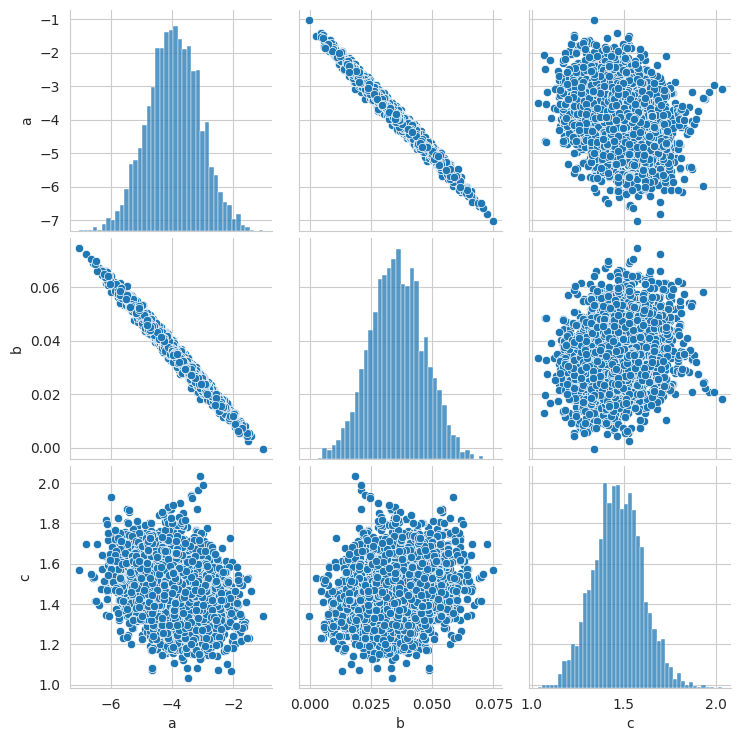

In [9]:
sns.pairplot(df_p)

In [10]:
corr_matrix = df_p.corr()
corr_matrix

parameters,a,b,c
parameters,,,
a,1.000000,-0.991989,-0.286734
b,-0.991989,1.000000,0.202855
c,-0.286734,0.202855,1.000000


**Observation:**

From the plot and correlation matrix above, the hyper-parameters **'a'** and **'b'** of our model are highly negatively correlated. This suggests the redundancy in selection of 3 hyper-parameters, instead we can re-model using only 2 hyper-parameters.

##### $95$ % Confidence interval of the hyper-parameters

In [11]:
quantiles_a_1 = df_p['a'].quantile([0.025, 0.975]).to_list()
quantiles_b_1 = df_p['b'].quantile([0.025, 0.975]).to_list()
quantiles_c_1 = df_p['c'].quantile([0.025, 0.975]).to_list()

print('95% CI of hyper-parameter:')
print('a:', quantiles_a_1)
print('b:', quantiles_b_1)
print('c:', quantiles_c_1)

95% CI of hyper-parameter:
a: [-5.627147154670174, -2.2596018586126836]
b: [0.013837847982455676, 0.057490493824162624]
c: [1.2113227758642813, 1.7341739020135112]


**Remark:**

With $95$ % confidence we can say that:

* The intercept $'a'$ is negative.
* Since $'b'$ and $'c'$ are positive $\implies$ both variables $AGE$ and $APOE4$ are positively related to the diagnosis of the disease.
* Since $'b'$ is far less than $'c'$ $\implies$ the effect of variable $AGE$ is very less compared to $APOE4$.

##### Baseline probability of the Model 1

The probability of positive diagnosis of the Model $1$ when the variables $AGE$ and $APOE4$ are not included in analysis i.e., we do not consider any information about the patient yet.

In [12]:
logistic_a_1_l = np.exp(quantiles_a_1[0])/(1 + np.exp(quantiles_a_1[0]))
logistic_a_1_h = np.exp(quantiles_a_1[1])/(1 + np.exp(quantiles_a_1[1]))

print('95 % CI for Baseline probability of the disease for Model 1: \n')
print('2.5 %  :', logistic_a_1_l)
print('97.5% :', logistic_a_1_h)

95 % CI for Baseline probability of the disease for Model 1: 

2.5 %  : 0.0035859224780417616
97.5% : 0.09452444019966319


**Remark:**

* Model $1$ is highly confident that a patient does not have the disease.
* In general, this very low probability shows that the model cannot make decision without the information about the $AGE$ and $APOE4$ of the patient.
* This also indicates more bias in the model, since ideally we would like to have the baseline probability close to decision boundary (which is $0.5$)

**2) Consider subjects who are 80 years old and check the effect of the APOE4 gene on the diagnosis.**

Hint: You'll draw many samples from two binomial distributions. One where APOE4 is included in the computation of $p_i$ and one where it's not.

> # Exercise 2- Solution:

**For an $80$ year old subject there are three possible combinations of $#$ copies of APOE4 gene i.e., $0,$ $1$ $\&$ $2$.**

In [13]:
def pi_1(age, apoe4):
    linear_reg = df_p['a'] + df_p['b'] * age + df_p['c'] * apoe4
    p_i = 1 / (1 + np.exp(-linear_reg))
    return p_i

In [14]:
p_i_g0 = pi_1(80, 0)
p_i_g1 = pi_1(80, 1)
p_i_g2 = pi_1(80, 2)

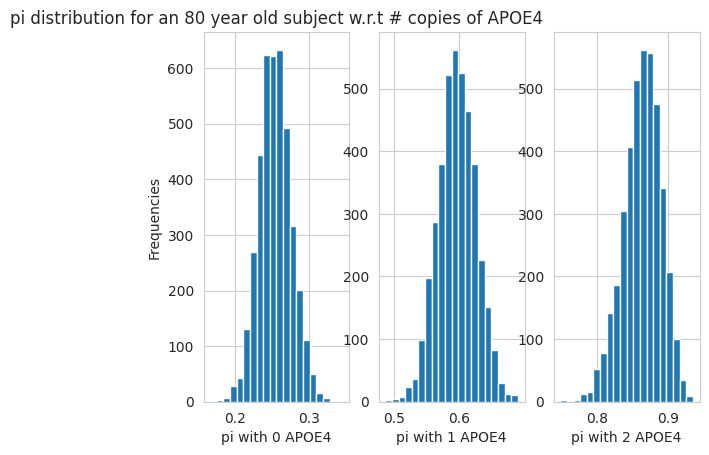

In [15]:
plt.subplot(1,3,1)
plt.hist(p_i_g0, bins=20)
plt.title('pi distribution for an 80 year old subject w.r.t # copies of APOE4')
plt.ylabel('Frequencies')
plt.xlabel('pi with 0 APOE4')
plt.subplot(1,3,2)
plt.hist(p_i_g1, bins=20)
plt.xlabel('pi with 1 APOE4')
plt.subplot(1,3,3)
plt.hist(p_i_g2, bins=20)
plt.xlabel('pi with 2 APOE4')
plt.show()

In [16]:
quantiles_pi_g0 = p_i_g0.quantile( [0.025, 0.975]).to_list()
quantiles_pi_g1 = p_i_g1.quantile( [0.025, 0.975]).to_list()
quantiles_pi_g2 = p_i_g2.quantile( [0.025, 0.975]).to_list()

print('95% CI of pi with # copies of the APOE4 gene:')
print('0:', quantiles_pi_g0)
print('1:', quantiles_pi_g1)
print('2:', quantiles_pi_g2)

95% CI of pi with # copies of the APOE4 gene:
0: [0.2121267387612645, 0.29880891129544385]
1: [0.5400674684909754, 0.6514989394866062]
2: [0.8061806032846233, 0.9093141464347387]


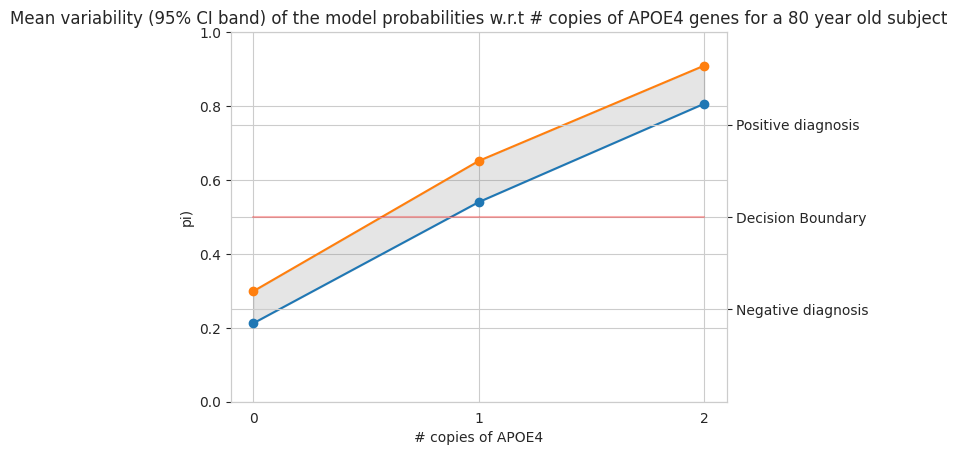

In [17]:
lower_quantiles = [quantiles_pi_g0[0], quantiles_pi_g1[0], quantiles_pi_g2[0]]
upper_quantiles = [quantiles_pi_g0[1], quantiles_pi_g1[1], quantiles_pi_g2[1]]

plt.plot(apoe4_genes,lower_quantiles, '-o')
plt.plot(apoe4_genes,upper_quantiles, '-o')
plt.fill_between([0,1,2], lower_quantiles, upper_quantiles, color='gray', alpha=0.2)
plt.xticks(apoe4_genes)
plt.xlabel('# copies of APOE4')
plt.ylabel('pi)')
plt.title("Mean variability (95% CI band) of the model probabilities w.r.t # copies of APOE4 genes for a 80 year old subject")
plt.ylim(0,1)
aux = plt.gca().twinx()
aux.plot(apoe4_genes,[0.5]*3,color='red', alpha=0.3)
aux.set_ylim(0,1)
aux.set_yticks([0.25, 0.5, 0.75])
ticks = aux.set_yticklabels(["Negative diagnosis", "Decision Boundary", 'Positive diagnosis'])

### Effect of the APOE4 gene on the diagnosis

For an $80$ year old subject, the following observations can be made using the plots above with $95$ % confidence:
* The subjects with no $APOE4$ genes, does not have the disease.
* The subjects with both $1$ and $2$ copies of $APOE4$ gene, have the disease.
* The probabilities of the disease diagnosis increases linearly with increase in the number of copies of $APOE4$ gene present in the subjects.

**3) In the last lesson, we fitted a model to predict the diagnosis using only the size of the brain (norm_brain). Compare this model and the one of question 1 in terms of WAIC. Is one better than the other ?**

> # Exercise 3- Solution:

## Model $2$ Description:

$$ y_i \sim Binomial(1,p_i), $$

$y_i:$ Binary Classification (i.e., $0$ or $1$) to predict a diagnosis (DX).

Parameter to estimate $\implies$ $p_i:$ -denotes the probability of diagnosis (i.e., $p(y_i = DX =$ $1$)).

Therefore, $y_i =$ $0$ for $p_i \leq$ $0.5$ and $1$ otherwise.

We parameterize (using parameters "a" & "b") the probability of a subject, $p_i$, with a **Logistic Regression Model**, as a linear combination of the predictor ($norm{\_}brain$).

The model is given as:

$$p_i = \frac{\exp(a + b (norm{\_}brain_i))}{1 + \exp(a + b (norm{\_brain}_i))}. $$

In [18]:
binomial_model_2 = """
data {
  int<lower=1> N;
  int y[N];
  real x[N];
}
parameters {
  real a;
  real b;
}
transformed parameters {
  vector[N] p_i;
  for (i in 1:N) {
    p_i[i] = exp(a + b * x[i])/(1 + exp(a + b * x[i]));
    }
}
model {
  b ~ normal(0, 3);
  a ~ normal(0, 3);
  y ~ binomial(1, p_i);
}
"""


In [19]:
data_to_stan_2 = dict(x = np.array(data_ct_ad['norm_brain']), y = np.array(data_ct_ad['DX']), N = len(data_ct_ad['DX']))

seed = 123

posterior = stan.build(binomial_model_2, data=data_to_stan_2, random_seed=seed)

Building...



Building: found in cache, done.

In [20]:
fit_2 = posterior.sample(num_chains=4, num_samples=1000)
df_2 = fit_2.to_frame()
print(df_2.T[:10])

Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   9% (700/8000)
Sampling:  15% (1200/8000)
Sampling:  20% (1600/8000)
Sampling:  41% (3300/8000)
Sampling:  61% (4900/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000211 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.11 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: binomial_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/tmp/httpstan_ol9jsan_/model_xte57mq4.stan', line 20, column 2 to column 23)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

draws                0           1           2           3           4     \
parameters                                                                  
lp__          -459.480952 -459.641495 -459.366684 -459.391449 -460.669330   
accept_stat__    1.000000    0.863033    0.989330    0.995092    0.907469   
stepsize__       0.812881    0.859752    0.784821    0.819601    0.812881   
treedepth__      1.000000    2.000000    3.000000    2.000000    2.000000   
n_leapfrog__     1.000000    3.000000    7.000000    7.000000    3.000000   
divergent__      0.000000    0.000000    0.000000    0.000000    0.000000   
energy__       459.653417  462.655082  459.966797  459.624451  460.785556   
a               -0.527383   -0.511488   -0.540789   -0.535464   -0.494131   
b               -1.157090   -1.159228   -1.149301   -1.125972   -1.000162   
p_i.1            0.627832    0.631989    0.623035    0.619305    0.601982   

draws                5           6           7           8           9     

In [21]:
est_a_2 = fit_2['a'][0]
quantiles_a = np.quantile(est_a_2, [0.05, 0.5, 0.975])

est_b_2 = fit_2['b'][0]
quantiles_b = np.quantile(est_b_2, [0.05, 0.5, 0.975])

logistic_a_50 = np.exp(quantiles_a[1])/(1 + np.exp(quantiles_a[1]))
logistic_a_5 = np.exp(quantiles_a[0])/(1 + np.exp(quantiles_a[0]))
logistic_a_95 = np.exp(quantiles_a[2])/(1 + np.exp(quantiles_a[2]))

print('Baseline probability of disease for Model 2: \n')
print('5%  :', logistic_a_5)
print('50% :', logistic_a_50)
print('95% :', logistic_a_95)

Baseline probability of disease for Model 2: 

5%  : 0.3276064042904434
50% : 0.3585083699391747
95% : 0.3968483627776465


### Observation:

The baseline probability for Model $2$ is close to the decision boundary ($0.5$), this indicates that Model $2$ has lower bias than Model $1$.

In [22]:
def waic (input_data, probabilities, n_dist_samples = None):
    if (n_dist_samples == None):
        n_dist_samples = probabilities.shape[1]
    lppd = []
    pwaic = []
    for i in range(len(input_data)):
        id_log_lik = []
        for k in range(n_dist_samples):
            p = probabilities[i,k]
            id_log_lik.append(binom.logpmf(input_data.values[i], 1, p))
        lppd.append(logsumexp(id_log_lik) - np.log(len(id_log_lik)))
        pwaic.append(np.var(id_log_lik))

    return -2 * (np.sum(lppd) -np.sum(pwaic))

In [23]:
p_i_M1 = fit_1['p_i']
p_i_M2 = fit_2['p_i']

waic_1 = waic(data_ct_ad['DX'], p_i_M1, 1000)
waic_2 = waic(data_ct_ad['DX'], p_i_M2, 1000)

print("WAIC for the Model 1 with Age and APOE4 as predictors is: ", waic_1)
print("WAIC for the Model 2 with norm_brain as predictor is: ", waic_2)

WAIC for the Model 1 with Age and APOE4 as predictors is:  951.7153220738338
WAIC for the Model 2 with norm_brain as predictor is:  922.3778804154518


**The Model 2 with norm_brain as a predictor performs better than Model 1, since its WAIC value is lower.**